# First assignment: Compute different measures on a realistic graph

In [1]:
import numpy as np
import urllib.request as urllib
import io
import zipfile

import networkx as nx
import matplotlib.pyplot as plt
import scipy
import collections
import random

## Load dataset

In [3]:


def load_dataset():
    
    
    
    # create graph
    G = nx.Graph()
    node_list = []
    edge_list = {}
    N = 0

    with open("dataset/facebook_combined.edges") as edges:
        
        
        for row in edges:
            if len(row.split(" ")) == 1:
                continue
        
            source, target = row.split(" ")[:2]
            source = int(source)
            target = int(target)
                        
            # add nodes if not in yet
            if source not in G:
                G.add_node(source)
        
            if target not in G:
                G.add_node(target)
        
            # add edge
            G.add_edge(source, target)
            
        # total number of nodes
        N = nx.number_of_nodes(G)
                
        return G
    
    return None


### Compute metrics

In [4]:
# load graph with all nodes
G = load_dataset()

# number of nodes
N = nx.number_of_nodes(G)
print("Number of nodes: ", N)

# number of links
print("Number of edges: ", nx.number_of_edges(G))

# average degree
print("Average degree: ", sum([d for n, d in G.degree()])/nx.number_of_nodes(G))

# Density
print("Density: ", nx.density(G))

# Global clustering
print("Global clustering: ", nx.transitivity(G))

# Average clustering
print("Average clustering: ", nx.average_clustering(G))


Number of nodes:  4039
Number of edges:  88234
Average degree:  43.69101262688784
Density:  0.010819963503439287
Global clustering:  0.5191742775433075
Average clustering:  0.6055467186200876


#### Find the largest connected component if necessary

In [5]:
if not nx.is_connected(G):
    print("graph not connected! From now on the largest component will be considered as the graph")  
    G =  G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]).copy()
    
print("Number of nodes of the giant component: ", nx.number_of_nodes(G))


Number of nodes of the giant component:  4039


In [14]:
print("Diameter: ", nx.diameter(G))

print("Average distance ", nx.average_shortest_path_length(G))

print("Assortativity coeff. ", nx.degree_pearson_correlation_coefficient(G))

Diameter:  8
Average distance  3.6925068496963913
Assortativity coeff.  0.06357722918564919


#### Does the graph have the same characteristics of a random or a power-law network?

In [7]:
from scipy.optimize import curve_fit
from scipy.special import zetac

# curve to fit
def func(k, c, gamma):
    return  k**(-gamma) * c


#### Plot degree distribution and fitted curve

<ipython-input-7-8f7a10451bd9>:5: RuntimeWarning: overflow encountered in power
  return  k**(-gamma) * c


[169.68055872   0.50668279]


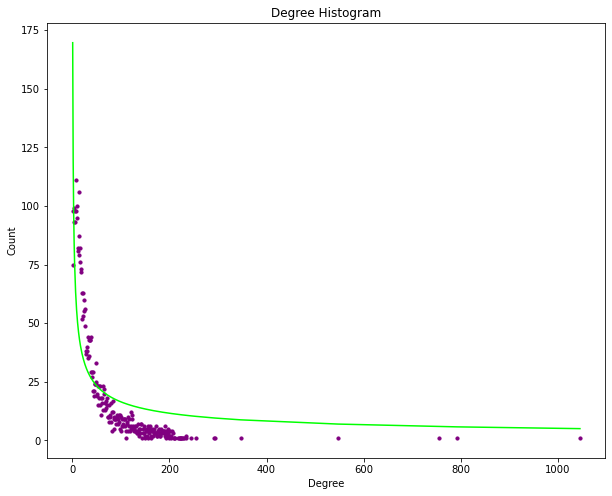

In [8]:
plt.figure(figsize=(10, 8))

degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
deg= np.array(deg)
cnt = np.array(cnt)

#fig, ax = plt.subplots()
plt.scatter(deg, cnt,s=10, color="purple")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
# prep axes                                                                                                                                                                                                                                  
                                                                                                            

#ax.set_xticks([d for d in deg])
#ax.set_xticklabels(deg)

popt, pcov = curve_fit(func, deg, cnt )

print("c, gamma: ", popt)

plt.plot(deg, func(deg,*popt), color='lime')
plt.savefig("images/degree_distribution.png")
plt.show()


#### Plot in logarithmic scale

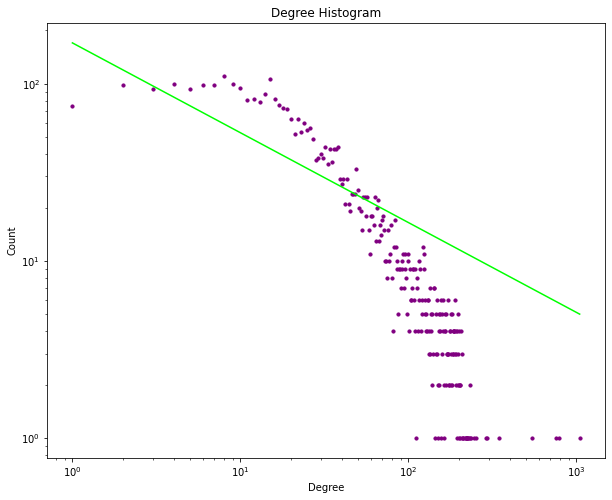

In [13]:
plt.figure(figsize=(10, 8))

plt.scatter(deg, cnt,s=10, color="purple")
plt.plot(deg, func(deg,*popt), color='lime')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')

plt.savefig("images/fitted_curve_degree_distribution.png")
plt.show()



#### Compute behaviour of the distance as the network grows 

In [5]:

node_set= set() # list of possible nodes that can be selected

# take a small set of nodes
init_node = random.sample([node for node ,degree in G.degree()], 50)

# add neighbors of the current nodes
for node in init_node:
    node_set.update(G.neighbors(node))
    
# add further nodes and edges starting from those already selected
further_nodes = random.sample(node_set, 950)
init_node = init_node + further_nodes

# remove nodes have been selected
node_set.difference_update(further_nodes)

for node in further_nodes:
    node_set.update(G.neighbors(node))
    

# first graph is a subgraph of 1000 nodes 
Gp = G.subgraph(init_node)

step = 100 # step of nodes
d_list = [] # list of distances

k_list = np.arange(1000, N, step)


for K in k_list:
    
    print(K)
    
    # add further nodes and edges starting from those already selected
    further_nodes = random.sample(node_set, step)
    init_node = init_node + further_nodes
    
    # remove nodes have been selected
    node_set.difference_update(further_nodes)

    for node in further_nodes:
        node_set.update(G.neighbors(node))
    
    Gp = G.subgraph(init_node)

    # if it is not connected select only the 
    if not nx.is_connected(Gp):
        Gp = Gp.subgraph(max(nx.connected_components(Gp), key=len)).copy()
    
    d_list.append(nx.average_shortest_path_length(Gp))
    

1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


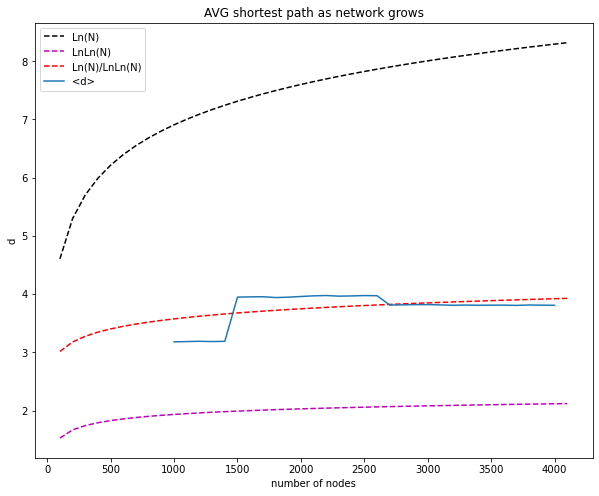

In [6]:
# plot linecharts
plt.figure(figsize=(10, 8))


x_list = np.arange(100, N + step, step)

plt.plot(x_list, [ np.log(x) for x in x_list ], "k--", label = "Ln(N)")
plt.plot(x_list, [ np.log(np.log(x)) for x in x_list ], "m--", label = "LnLn(N)")
plt.plot(x_list, [ np.log(x)/np.log(np.log(x)) for x in x_list ], "r--", label = "Ln(N)/LnLn(N)")
plt.plot(k_list, d_list, label="<d>")

plt.title("AVG shortest path as network grows")
plt.ylabel("d")
plt.xlabel("number of nodes")
plt.legend()

plt.savefig("images/grow_network.png")

plt.show()

#### Which are the most important nodes, with respect to a given centrality measure?

In [34]:

k= 10 # top k node

betwenness = nx.betweenness_centrality(G)

# select first k
betwenness = dict(sorted(betwenness.items(), key=lambda item: item[1], reverse=True)[:k])

print("Betwenness: ", betwenness)

closeness = nx.closeness_centrality(G)

# select first k
closeness = dict(sorted(closeness.items(), key=lambda item: item[1], reverse=True)[:k])

print("Closeness: ", closeness)


# select first k

degree = G.degree()
degree = dict(sorted(degree, key=lambda item: item[1], reverse=True)[:k])

print("Degree: ",degree)

Betwenness:  {107: 0.4805180785560152, 1684: 0.3377974497301992, 3437: 0.23611535735892905, 1912: 0.2292953395868782, 1085: 0.14901509211665306, 0: 0.14630592147442917, 698: 0.11533045020560802, 567: 0.09631033121856215, 58: 0.08436020590796486, 428: 0.06430906239323866}
Closeness:  {107: 0.45969945355191255, 58: 0.3974018305284913, 428: 0.3948371956585509, 563: 0.3939127889961955, 1684: 0.39360561458231796, 171: 0.37049270575282134, 348: 0.36991572004397216, 483: 0.3698479575013739, 414: 0.3695433330282786, 376: 0.36655773420479304}
Degree:  {107: 1045, 1684: 792, 1912: 755, 3437: 547, 0: 347, 2543: 294, 2347: 291, 1888: 254, 1800: 245, 1663: 235}
